In [1]:
import torch

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [3]:
!pip install torchmetrics

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_score
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support
from torchmetrics import Precision, Recall, F1Score, Accuracy
from torchmetrics.classification import accuracy
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 4.4 MB/s 



#### STEPS:
- load FashionMNIST
- load tensor into dataset and add dataloader
- create your custom loss fn
- Define the convolution autoencoder model with 
- test on single datapoint
- train the network using loss fn and optimiser
- test using (x,x)



In [4]:
def load_data():

    # Download training data from open datasets.
    training_data = datasets.FashionMNIST(
        root="data",
        train=True,
        download=True,
        transform=ToTensor(),
    )

    # Download test data from open datasets.
    test_data = datasets.FashionMNIST(
        root="data",
        train=False,
        download=True,
        transform=ToTensor(),
    )
    return training_data, test_data

In [5]:
train_data,test_data=load_data()


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [6]:
# create dataloader
# generate a DataLoder by using this Dataset.
batch_size=32
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
# loss_fn = torch.nn.MSELoss()

In [7]:
# Convolutional Autoencoder
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class CS21M012(nn.Module):
    def __init__(self):
        super(CS21M012, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3,padding=1)  
        self.conv2 = nn.Conv2d(32, 14, 3,padding=1)
      
        self.pool = nn.MaxPool2d(2, 2)
        
    
        self.t_conv1 = nn.ConvTranspose2d(14, 7, 2,stride=2)
        self.t_conv2 = nn.ConvTranspose2d(7, 1, 2,stride=2)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)  
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x

In [19]:
X0,y0=train_data[0]
X0.shape

torch.Size([1, 28, 28])

In [22]:
conv1 = nn.Conv2d(1, 28, 3,padding=1)
conv2 = nn.Conv2d(28,14,3,padding=1)
pool = nn.MaxPool2d(2,2)
t1=nn.ConvTranspose2d(14, 7, 2,stride=2)
t2=nn.ConvTranspose2d(7, 1, 2,stride=2)

x = X0
print(x.shape)
x = conv1(x)
x=pool(x)

print(x.shape)

x = conv2(x)
x=pool(x) # flatten all dimensions except batch
print(x.shape)


x = t1(x)
print(x.shape)
# print(x.shape)
# x = fc3(x)
x = t2(x)
print(x.shape)
# print(x.shape)
      

torch.Size([1, 28, 28])
torch.Size([28, 14, 14])
torch.Size([14, 7, 7])
torch.Size([7, 14, 14])
torch.Size([1, 28, 28])


In [10]:
def loss_fn(x_input, x_constructed):                        #x_input and x_constructed here should be tensors here
    loss = torch.mean((x_input-x_constructed)**2)
    return loss

In [11]:
model = CS21M012()
model.double()

CS21M012(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(14, 7, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(7, 1, kernel_size=(2, 2), stride=(2, 2))
)

In [12]:
model = CS21M012()
model = CS21M012().to(device)

In [13]:
optim = torch.optim.SGD(model.parameters(), lr=1e-3)

In [14]:
import torch.optim as optim
import torch.nn.functional as F

model = CS21M012().to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-6)
model.train()
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader):
      X, y = data
      pred = model(X)
      loss = loss_fn(pred, torch.tensor(X))
      loss.backward()
      
      # print statistics
      running_loss += loss.item()
      if i % 100 == 0:    # print every 2000 mini-batches
          print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
          running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.000
[1,   101] loss: 0.011
[1,   201] loss: 0.011
[1,   301] loss: 0.011
[1,   401] loss: 0.011
[1,   501] loss: 0.011
[1,   601] loss: 0.011
[1,   701] loss: 0.011
[1,   801] loss: 0.011
[1,   901] loss: 0.011
[1,  1001] loss: 0.011
[1,  1101] loss: 0.011
[1,  1201] loss: 0.011
[1,  1301] loss: 0.011
[1,  1401] loss: 0.011
[1,  1501] loss: 0.011
[1,  1601] loss: 0.011
[1,  1701] loss: 0.011
[1,  1801] loss: 0.011
[2,     1] loss: 0.000
[2,   101] loss: 0.011
[2,   201] loss: 0.011
[2,   301] loss: 0.011
[2,   401] loss: 0.011
[2,   501] loss: 0.011
[2,   601] loss: 0.011
[2,   701] loss: 0.011
[2,   801] loss: 0.011
[2,   901] loss: 0.011
[2,  1001] loss: 0.011
[2,  1101] loss: 0.011
[2,  1201] loss: 0.011
[2,  1301] loss: 0.011
[2,  1401] loss: 0.011
[2,  1501] loss: 0.011
[2,  1601] loss: 0.011
[2,  1701] loss: 0.011
[2,  1801] loss: 0.011
[3,     1] loss: 0.000
[3,   101] loss: 0.011
[3,   201] loss: 0.011
[3,   301] loss: 0.011
[3,   401] loss: 0.011
[3,   501] 

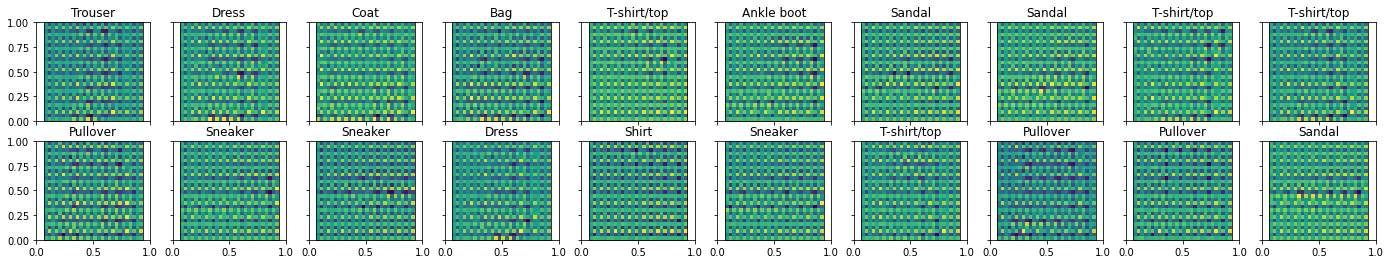

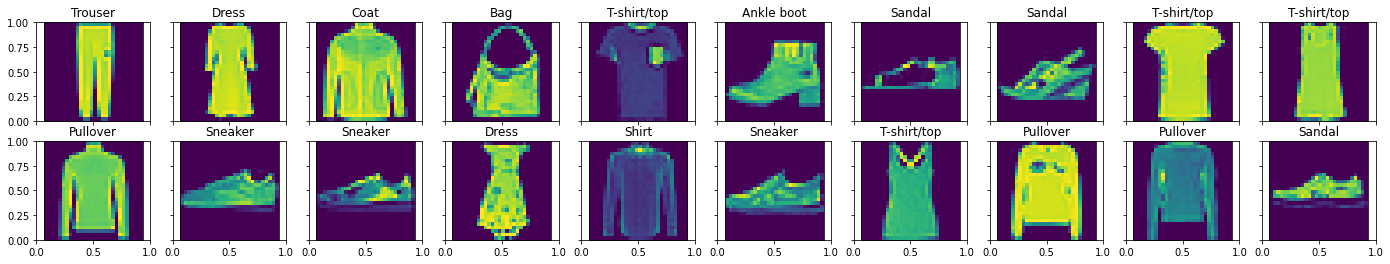

In [15]:
import numpy as np
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()
batch_size=64

# output is resized into a batch of images
#output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# # plot the first ten input images and then reconstructed images
# fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))

# # input images on top row, reconstructions on bottom
# for images, row in zip([images, output], axes):
#     for img, ax in zip(images, row):
#         ax.imshow(np.squeeze(img))
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    x=output[idx]
    # print(x.shape)
    # print(output[idx].shape)
    
    plt.imshow(x.reshape(x.shape[1],x.shape[2]))
    ax.set_title(classes[labels[idx]])
    
# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx].reshape(images[idx].shape[1],images[idx].shape[2]))
    ax.set_title(classes[labels[idx]])

